In [1]:
from sklearn import mixture
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
def tic():
    # MATLAB tic、toc函数实现
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()
def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [4]:
# 辅助函数
def random_pdmat_gen(matrixSize):
    '''
    返回matrixSize * matrixSize的pos-def matrix
    '''
    A = np.random.rand(matrixSize, matrixSize)
    return np.dot(A, A.T)
def random_posdefmat(Ns, matrixSize):
    '''
    Ns个matrixSize * matrixSize矩阵组成的Ns * matrixSize * matrixSize张量
    '''
    X = np.zeros((Ns, matrixSize, matrixSize))
    for s in range(Ns):
        X[s, :, :] = random_pdmat_gen(matrixSize)
    return X
def random_pmf(Nc):
    p_unnorm = np.random.rand(Nc)
    return p_unnorm / p_unnorm.sum()

########################################
# 可视化样本前三维
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_3D(X_samples, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x = X_samples[:, 0]
    y = X_samples[:, 1]
    z = X_samples[:, 2]
    
    ax.scatter(x, y, z, c='r', marker='o')
    ax.set_title(title)

In [5]:
# 设置GMM的均值、方差、初始概率
Nc = 4
Ndim = 3

pi_vec = random_pmf(Nc)

mu_gen = np.array([[1, -1, 1], [-1, 1, 1], [1, 1, 1], [-1, -1, -1]])

Sig_gen = 0.01* random_posdefmat(Nc, Ndim)

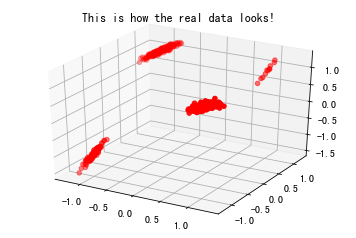

In [6]:
# 产生n个Ndim-D维高斯分布的iid(独立同分布)样本 
n_samples = 500

# 随机初始化每个样本的聚类下标
cluster_indices = np.random.choice(Nc, n_samples, p=pi_vec, replace=True)
X_samples = np.zeros((n_samples, Ndim))
for s in range(n_samples):
    ind_s = cluster_indices[s]
    X_samples[s, :] = np.random.multivariate_normal(mu_gen[ind_s, :], Sig_gen[ind_s, :, :], 1)
plot_3D(X_samples, 'This is how the real data looks!')


In [7]:
# 使用变分定理(Variational Inference)学习均值(mean)和方差(variances)
tic()
dpgmm = mixture.BayesianGaussianMixture(n_components=Nc, covariance_type='full').fit(X_samples)
toc()

Elapsed time is 0.017752885818481445 seconds.


In [9]:
mu_est = dpgmm.means_
pi_est = dpgmm.weights_
Sig_est = dpgmm.covariances_

In [11]:
# 数值化计算估计均值和均值, 然后找到cluster-real和custer-estimated映射
i = 0
map_ind = np.zeros(Nc, dtype=int)
for p in pi_vec:
    map_ind[i] = int(np.argmin(np.abs(pi_est - p)))
    i += 1
print("The mapping of the cluster indices are:")
print(map_ind)
print("Results: True means")
print(mu_gen)
print("Results: Predicted means")
mu_est[map_ind,:]

The mapping of the cluster indices are:
[1 0 3 2]
Results: True means
[[ 1 -1  1]
 [-1  1  1]
 [ 1  1  1]
 [-1 -1 -1]]
Results: Predicted means


array([[ 1.01461395, -0.9919083 ,  1.00905002],
       [-0.99310551,  0.99938587,  1.0002538 ],
       [ 0.8889215 ,  0.88961341,  0.93848482],
       [-0.98993225, -0.9882856 , -0.97847754]])

In [12]:
# 可视化真实GMM和估计GMM的数据
# 首先产生估计GMM产生的数据
X_synthetic = np.zeros((n_samples, Ndim))
cluster_indices = np.random.choice(Nc, n_samples, p=pi_est, replace=True)
for s in range(n_samples):
    ind_s = cluster_indices[s]
    X_synthetic[s, :] = np.random.multivariate_normal(mu_est[ind_s, :], Sig_est[ind_s, :])

<Figure size 432x288 with 0 Axes>

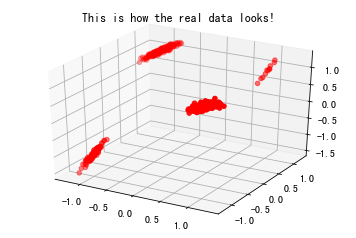

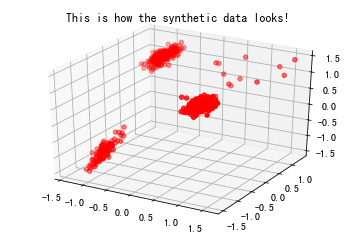

In [13]:
# 可视化两个GMM
plt.figure()
plot_3D(X_samples, 'This is how the real data looks!')
plot_3D(X_synthetic, 'This is how the synthetic data looks!')

In [16]:
# 客户端模型更新
# n_e个样本, n_m个混合
from scipy.stats import multivariate_normal as MVN
Y_enroll = X_synthetic
n_e = Y_enroll.shape[0]
n_m = Nc
p_mat = np.zeros((n_e, n_m))
for q in range(n_e):
    y_q = Y_enroll[q, :]
    for i in range(n_m):
        p_mat[q, i] = pi_est[i] *MVN.pdf(y_q, mean=mu_est[i, :], cov=Sig_est[i, :, :])

norm_den = p_mat.sum(axis=1)
Pr_i_q = p_mat / norm_den.reshape(n_e, 1)

In [17]:
r_hyp = 4
n_i_vec = Pr_i_q.sum(axis=0)
alpha_i_vec = n_i_vec/(n_i_vec + r_hyp)

In [18]:
# E_i_Yenroll: This is the per-mixture mean given the Enrollment dataset
mu_update = np.zeros((n_m, Ndim))
E_i = np.zeros((n_m, Ndim))
for i in range(n_m):
    e_i = np.zeros(Ndim)
    for q in range(n_e):
        y_q = Y_enroll[q, :]
        e_i += Pr_i_q[q, i]*y_q
    n_i = n_i_vec[i]
    E_i[i, :] = e_i / n_i
    mu_i = mu_est[i, :]
    alpha_i = alpha_i_vec[i]
    mu_update[i, :] = alpha_i * E_i[i, :] + (1 -alpha_i) * mu_i
print('After getting some more data and updated the mean, the updated mean looks like:')
mu_update

After getting some more data and updated the mean, the updated mean looks like:


array([[-0.97334078,  1.01344754,  1.02666084],
       [ 1.02083173, -0.98593968,  1.01703988],
       [-0.98717307, -0.99343321, -0.97931693],
       [ 0.78651621,  0.86298137,  0.91987353]])

<Figure size 432x288 with 0 Axes>

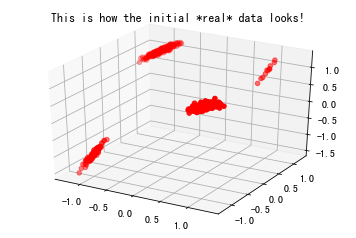

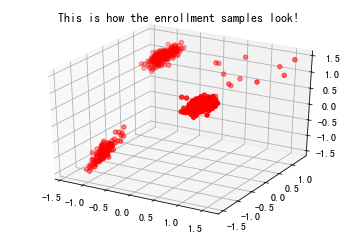

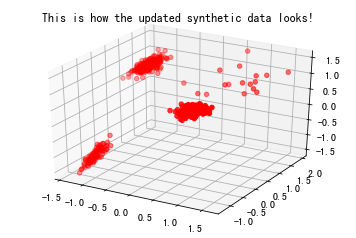

In [22]:
X_synthetic_new = np.zeros((n_samples, Ndim))
cluster_indices = np.random.choice(Nc, n_samples, p=pi_est, replace=True)
for s in range(n_samples):
    ind_s = cluster_indices[s]
    X_synthetic_new[s, :] = np.random.multivariate_normal(mu_update[ind_s, :], Sig_est[ind_s, :, :])
plt.figure()
plot_3D(X_samples, 'This is how the initial *real* data looks!')
plot_3D(X_synthetic, 'This is how the enrollment samples look!')
plot_3D(X_synthetic_new, 'This is how the updated synthetic data looks!')

In [24]:
# 进行相关函数构造
def learn_UBM(X_train, M, cov_type='tied', train_algo='DP'):
    if train_algo=='DP':
        model_UBM = mixture.BayesianGaussianMixture(n_components=M, covariance_type=cov_type).fit(X_train)
    else:
        model_UBM = mixture.GaussianMixture(n_components=M, covariance_type=cov_type).fit(X_train)
    return model_UBM

def enroll_user(X_test, model_UBM):
    N = X_test.shape[0]
    score_user = model_user.score(X_test)
    score_UBM = model_UBM.score(X_test)
    mean_diff_score= (model_user.score(X_test) - model_UBM.score(X_test))
    return mean_diff_score, score_user, score_UBM

def score_user_data(X_test, model_user, model_UBM):
    N = X_test.shape[0]
    score_user = model_user.score(X_test)
    score_UBM = model_UBM.score(X_test)
    mean_diff_score = (model_user.score(X_test)-model_UBM.score(X_test))
    return mean_diff_score, score_user, score_UBM
    

In [25]:
model_UBM = learn_UBM(X_samples, 4, train_algo='EM')
model_user =  learn_UBM(X_synthetic, 4, train_algo='EM')
score_user_data(X_synthetic_new, model_user, model_UBM)

(3.624403793105074, 0.746805614459549, -2.877598178645525)

In [26]:
print(model_user.bic(X_synthetic_new))
model_UBM.bic(X_samples)

-616.2988443926829


-2435.0031899767846

In [31]:
from scipy.stats import multivariate_normal as MVN
from copy import deepcopy

def enroll_user(Y_enroll, model_UBM, r_hyp=4):
    pi_est = model_UBM.weights_
    mu_est = model_UBM.means_
    Sig_est = model_UBM.covariances_
    n_m = model_UBM.n_components
    n_e = Y_enroll.shape[0]
    
    p_mat = np.zeros((n_e, n_m))
    for q in range(n_e):
        y_q = Y_enroll[q,:]
        for i in range(n_m):
            p_mat[q, i]= pi_est[i] * MVN.pdf(y_q, mean=mu_est[i,:], cov=Sig_est)
        
    # 归一化获得聚类集群的后验概率
    norm_den = p_mat.sum(axis=1)
    # 样本q属于聚类集群i的概率
    Pr_i_q = p_mat / norm_den.reshape(n_e, 1)
    r_hyp = 4
    n_i_vec = Pr_i_q.sum(axis=0)
    alpha_i_vec = n_i_vec/(n_i_vec + r_hyp)
    # E_i_Yenroll: This is the per-mixture mean given the Enrollment dataset
    mu_update = np.zeros((n_m, Ndim))
    E_i = np.zeros((n_m, Ndim))
    for i in range(n_m):
        e_i = np.zeros(Ndim)
        for q in range(n_e):
            y_q = Y_enroll[q, :]
            e_i += Pr_i_q[q, i]*y_q
        n_i = n_i_vec[i]
        E_i[i,:]=e_i /n_i
        mu_i = mu_est[i,:]
        alpha_i = alpha_i_vec[i]
        mu_update[i, :] = alpha_i* E_i[i, :]+(1-alpha_i)*mu_i
        model_user = deepcopy(model_UBM)
        model_user.means_ = mu_update
    return model_user
            

In [32]:
model_UBM = learn_UBM(X_samples, 4)
model_user = enroll_user(X_synthetic, model_UBM, r_hyp=4)
model_user.covariances_

array([[0.02527073, 0.00040263, 0.01481637],
       [0.00040263, 0.02029803, 0.01254685],
       [0.01481637, 0.01254685, 0.02399962]])

In [33]:
model_UBM.score(X_synthetic)

0.6737471103289793